# Импортируем библиотеки

In [2]:
import os
# path_to_data = '../../datasets/Machine_translation_EN_RU/data.txt'
# if not os.path.exists(path_to_data):
#     print("Dataset not found locally. Downloading from github.")
#     !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
#     path_to_data = './data.txt'

In [3]:
path_to_data = './data.txt'

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR, StepLR
from torch import Tensor

import torchtext
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer
from nltk.tokenize import wordpunct_tokenize
from nltk.translate.bleu_score import corpus_bleu

import tqdm
import numpy as np
import pandas as pd
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from timeit import default_timer as timer

# Preprocessing



In [6]:
MAX_SEQUENCE_LENGTH = 50
BATCH_SIZE = 128

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# ru_tokenizer = get_tokenizer('spacy', language='ru')
# en_tokenizer = get_tokenizer('spacy', language='en')

ru_tokenizer = wordpunct_tokenize
en_tokenizer = wordpunct_tokenize

In [8]:
# Step 1: Read the dataset file and parse it
def read_dataset(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    english_sentences = []
    russian_sentences = []
    for line in lines:
        english, russian = line.strip().split('\t')
        english_sentences.append(english)
        russian_sentences.append(russian)
    return english_sentences, russian_sentences

en_sentences, ru_sentences = read_dataset(path_to_data)

In [9]:
# Step 2: Tokenize the sentences
def tokenize_sentences(sentences, tokenizer):
    tokenized_sentences = [tokenizer(sentence.lower()) for sentence in sentences]
    return tokenized_sentences

ru_tokenized = tokenize_sentences(ru_sentences, ru_tokenizer)
en_tokenized = tokenize_sentences(en_sentences, en_tokenizer)

In [10]:
print(ru_tokenized[0])

['отель', 'cordelia', 'расположен', 'в', 'тбилиси', ',', 'в', '3', 'минутах', 'ходьбы', 'от', 'свято', '-', 'троицкого', 'собора', '.']


In [11]:
# Step 3: Create vocabulary mappings
def build_vocab(tokenized_sentences):
    counter = Counter()
    for sentence in tokenized_sentences:
        counter.update(sentence)
    vocab = torchtext.vocab.vocab(counter, min_freq=3, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
    vocab.set_default_index(vocab["<UNK>"])
    return vocab

ru_vocab = build_vocab(ru_tokenized)
en_vocab = build_vocab(en_tokenized)

In [12]:
SRC_VOCAB_SIZE = len(ru_vocab)
TGT_VOCAB_SIZE = len(en_vocab)
PAD_IDX = en_vocab['<PAD>']
SOS_IDX = en_vocab['<SOS>']
EOS_IDX = en_vocab['<EOS>']
UNK_IDX = en_vocab['<UNK>']

In [13]:
print(len(en_vocab))
print(len(ru_vocab))

7828
10799


In [14]:
# Step 4: Transform data to torch Tensor and make train, val, test split
data = []
for (ru_sentence, en_sentence) in zip(ru_tokenized, en_tokenized):
    ru_tensor_ = torch.tensor(ru_vocab.lookup_indices(ru_sentence), dtype=torch.long)
    en_tensor_ = torch.tensor(en_vocab.lookup_indices(en_sentence), dtype=torch.long)
    data.append((ru_tensor_, en_tensor_))

train_size = int(0.8 * len(data))
val_size = int(0.15 * len(data))
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

In [15]:
# Step 5: Make batches and data loaders
def generate_batch(data_batch):
    ru_batch, en_batch = [], []
    for (ru_item, en_item) in data_batch:
        ru_batch.append(torch.cat([torch.tensor([ru_vocab['<SOS>']]),
                                   ru_item,
                                   torch.tensor([ru_vocab['<EOS>']])
                                   ], dim=0))
        en_batch.append(torch.cat([torch.tensor([en_vocab['<SOS>']]),
                                   en_item,
                                   torch.tensor([en_vocab['<EOS>']])
                                   ], dim=0))
    ru_batch = pad_sequence(ru_batch, padding_value=ru_vocab['<PAD>'])
    en_batch = pad_sequence(en_batch, padding_value=en_vocab['<PAD>'])
    return ru_batch, en_batch


train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

In [16]:
batch = next(iter(train_loader))

In [17]:
print(batch[0].shape)

torch.Size([49, 128])


# Определение модели

In [67]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * np.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * np.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = nn.Transformer(d_model=emb_size,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor, src_padding_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask, 
                            src_key_padding_mask=src_padding_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor, memory_key_padding_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory, tgt_mask,
                          memory_key_padding_mask=memory_key_padding_mask)

In [68]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## Дополнительные функции

In [69]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [70]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

def my_rate(step, lr_max=0.001, step_max=50):
    if step == 0:
        step = 1
    return lr_max * step_max**0.5 * min(step ** (-0.5), step * step_max**(-1.5))

In [71]:
def train_epoch(model, optimizer, criterion, n_show = 50, if_scheduler=False, 
                train_history=[], valid_history=[], bleu_history=[]):
    model.train()
    
    epoch_loss = 0
    I_val = []
    epoch_history = []
    val_history = []
    nf_val_history = []
    bleu_scores = []
    for i, batch in tqdm.tqdm(enumerate(train_loader)):
        src = batch[0].to(DEVICE)
        tgt = batch[1].to(DEVICE)

        optimizer.zero_grad()

        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        if if_scheduler: lr_scheduler.step()
        
        epoch_history.append(loss.cpu().data.numpy())
        epoch_loss += loss.item()

        if (i+1) % n_show == 0:
            I_val.append(i)
            val_history.append(evaluate(model, val_loader, criterion))
            
            # bleu_score, _1, _2 = calc_bleu(model, val_loader)
            # bleu_scores.append(bleu_score)
            
            model.train()
            
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(11, 3))
    
            line_11, = ax[0].plot(epoch_history, label='train loss')
            line_12, = ax[0].plot(I_val, val_history, label='val loss')
            # line_13, = ax[0].plot(I_val, nf_val_history, label='no force val loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Loss')
            ax[0].legend()
            
            # line_21, = ax[1].plot(I_val, bleu_scores, label='Validation BLEU')
            # ax[1].set_xlabel('Batch')
            # ax[1].set_title('BLEU')            
            # ax[1].legend()
            
            if train_history != []:
                ax[1].plot(train_history, label='Train loss')
            if valid_history != []:
                ax[1].plot(valid_history, label='Valid loss')
            ax[1].legend()
            ax[1].set_xlabel('# of epoch')
            ax[1].set_title('Loss')
            
            if bleu_history != []:
                ax[2].plot(bleu_history, label='Validation BLEU' )
                ax[1].set_xlabel('# of epoch')
                ax[2].set_title('BLEU')            
                ax[2].legend()
            
            
            clear_output(True)
            plt.show()

    return epoch_loss / len(list(train_loader))


def evaluate(model, loader, criterion):
    model.eval()
    losses = 0

    for src, tgt in loader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(loader))

In [72]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, src_padding_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask, src_padding_mask)
    ys = torch.ones(1, src.shape[1]).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask, src_padding_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)

        ys = torch.cat([ys, next_word.unsqueeze(0)], dim=0)
    return ys

In [73]:
# Translate test data and get model translations
def calc_bleu(model, loader):
    translated_sentences = []
    target_sentences = []

    for batch in loader:
        model.eval()
        src = batch[0].to(DEVICE)
        trg = batch[1].to(DEVICE)

        num_tokens = src.shape[0]
        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
        src_padding_mask = (src == PAD_IDX).transpose(0, 1)

        with torch.no_grad():
            # Assuming your model returns token indices
            translated_indices = greedy_decode(model, src, src_mask, src_padding_mask,
                                               MAX_SEQUENCE_LENGTH, SOS_IDX)
            translated_indices = translated_indices.transpose(0, 1).cpu().tolist()

            for indices in translated_indices:
                tmp = []
                for idx in indices:
                    if idx == UNK_IDX or idx > 3:
                        tmp.append(en_vocab.lookup_token(idx))
                    elif idx == EOS_IDX:
                        break
                translated_sentences.append(tmp)

            trg_indices = trg.transpose(0, 1).cpu().tolist()
            for indices in trg_indices:
                tmp = []
                for idx in indices:
                    if idx == UNK_IDX or idx > 3:
                        tmp.append(en_vocab.lookup_token(idx))
                    elif idx == EOS_IDX:
                        break
                target_sentences.append(tmp)
            
    bleu_score = corpus_bleu([[text] for text in target_sentences], translated_sentences) * 100
    return bleu_score, translated_sentences, target_sentences

In [74]:
I = 0

# Инициализация и обучение

In [76]:
I += 1

EMB_SIZE = 256
NHEAD = 4
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
DROPOUT = 0.1

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM, DROPOUT)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)
print(f'The model has {count_parameters(transformer):,} trainable parameters')

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

The model has 9,417,108 trainable parameters


In [77]:
NUM_EPOCHS = 10
n_show = 100
if_scheduler = True
save_path = f'tr_{I}.pt'

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0002, betas=(0.9, 0.98), eps=1e-9)

if if_scheduler:
    # lr_scheduler = LambdaLR(optimizer=optimizer, lr_lambda=lambda step: my_rate(step, 0.0002, 2))

    lr_scheduler = StepLR(optimizer, step_size=200, gamma=0.92)

train_history = []
valid_history = []
bleu_scores = []

best_valid_loss = float('inf')

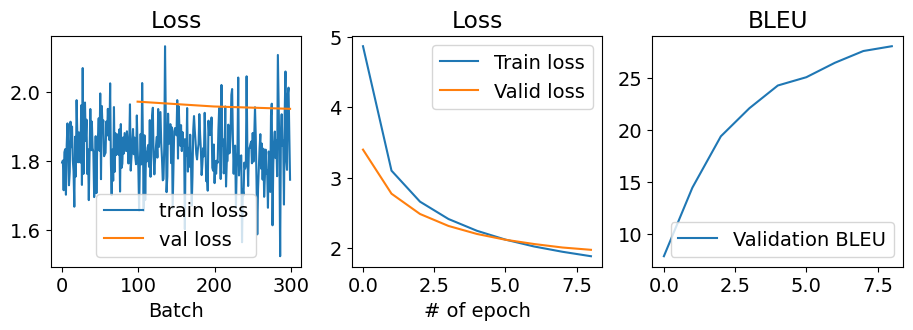

313it [00:08, 37.15it/s]


Epoch: 10, Train loss: 1.836, Val loss: 1.954,            Epoch time = 16.913s


In [78]:
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer,
                             optimizer,
                             criterion,
                             n_show, 
                             if_scheduler,
                             train_history,
                             valid_history,
                             bleu_scores)
    valid_loss = evaluate(transformer, val_loader, criterion)
    bleu_score, _1, _2 = calc_bleu(transformer, val_loader)
    end_time = timer()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        state = {
                'epoch': epoch,
                'state_dict': transformer.state_dict(),
                'optimizer': optimizer.state_dict()}
        torch.save(state, save_path)
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    bleu_scores.append(bleu_score)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {valid_loss:.3f}, \
           "f"Epoch time = {(end_time - start_time):.3f}s"))


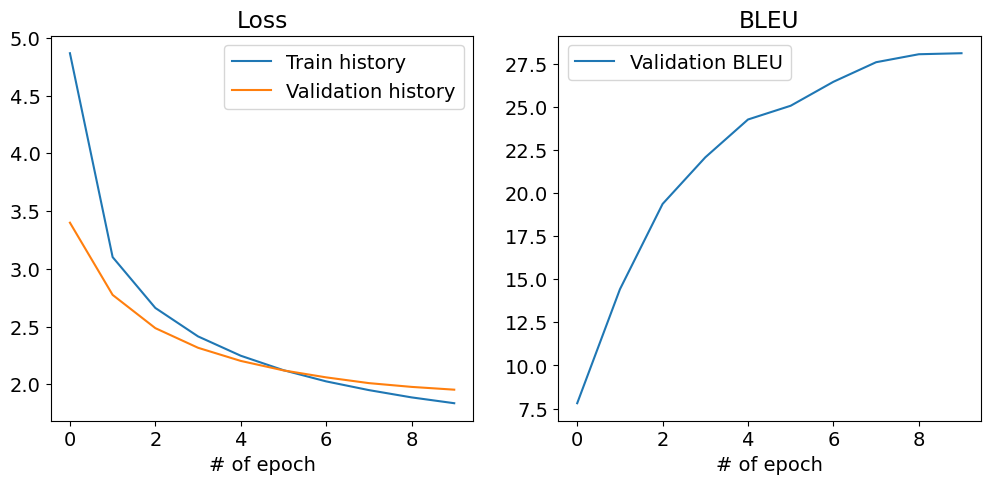

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[0].plot(train_history, label='Train history')
ax[0].plot(valid_history, label='Validation history')
ax[0].set_xlabel('# of epoch')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(bleu_scores, label='Validation BLEU')
ax[1].set_xlabel('# of epoch')
ax[1].set_title('BLEU')
plt.legend()

plt.show()

In [80]:
# Calculate BLEU score
bleu_score, translated_sentences, target_sentences = calc_bleu(transformer, test_loader)
print("BLEU Score:", bleu_score)

BLEU Score: 28.308685994470295


In [ ]:
state = torch.load(filepath)

transformer.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])